In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from typing import Dict, Optional

from pyciemss.utils import get_tspan

/Users/sam-basis/opt/anaconda3/envs/sw-demo-primitives/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Plotting Utilities

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    # ax.set_ylim(0, 1.1)
    ax.set_ylabel('Proportion of Individuals')
    return ax

def plot_predictive(prediction, tspan, plot_var, plot_index=None, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):


    if plot_index is not None:
        low = torch.quantile(prediction[plot_var][:, :, 0, plot_index], 0.05, dim=0).detach().numpy()
        up = torch.quantile(prediction[plot_var][:, :, 0, plot_index], 0.95, dim=0).detach().numpy()
    else:
        low = torch.quantile(prediction[plot_var], 0.05, dim=0).detach().numpy()
        up = torch.quantile(prediction[plot_var], 0.95, dim=0).detach().numpy()        

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], low[indeces], up[indeces], alpha=alpha, color=color, **kwargs)

    ax.set_xlabel('Time /days')

    return ax

def plot_trajectory(data, tspan, plot_var, plot_index=None, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if plot_index is not None:
        result = data[plot_var][:, :, 0, plot_index].squeeze().detach().numpy()
    else:
        result = data[plot_var].squeeze().detach().numpy()


    ax.plot(tspan, result, color, alpha=alpha, lw=lw, marker=marker, label=label)
    ax.set_xlabel('Time /days')
    
    return ax

# **Overview** 

## In this notebook we use pyciemss, an early prototype of the CIEMSS team's probabilistic programming software for simulation modeling, to answer a number of questions related to epidemiological analysis using a stratified SIR model. 

To emphasize our team's probabilistic reasoning capabilities, we have elaborated on the scenario questions to include uncertainty in model parameters.

To emphasize our team's causal reasoning capabilities, we have elaborated on the scenario questions to include more complicated interventions. Specifically, we explore interventions that can not simply be represented as a change in parameters, instead requiring manipulation of the simulation runtime.



## Model

The following model implements the stratified SIR scenario for all of the scenario questions. Note, that the model is defined over tensors of stratified $S$, $I$, and $R$ variables, where each element represents a different stratum. This means that the same model applies regardless of the number of stratum.

In [3]:
from pyro.nn import pyro_method

from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from pyciemss.utils import state_flux_constraint

class StratifiedSIR(ODE):
    def __init__(self,
                C_prior,
                Ro_prior,
                gamma_prior
                ):
        super().__init__()

        self.C_prior = C_prior
        self.Ro_prior = Ro_prior
        self.gamma_prior = gamma_prior

    @pyro_method
    def deriv(self, t: Time, state: State) -> State:
        '''
        This method defines the derivative of `state` as a function of `state` and `t`.
        '''
        
        S, I, R = state
        
        SI_flux = state_flux_constraint(S, pyro.deterministic("SI_flux %f" % (t), (torch.transpose(S, 0, 1) * I) * self.C * self.Ro).sum(axis=1))

        IR_flux = state_flux_constraint(I, pyro.deterministic("IR_flux %f" % (t), I * self.gamma))

        dSdt = -SI_flux
        dIdt = SI_flux - IR_flux
        dRdt = IR_flux

        return dSdt, dIdt, dRdt

    @pyro_method
    def param_prior(self) -> None:
        '''
        This method samples each parameter from its corresponding prior.
        '''

        self.C = pyro.sample("C", self.C_prior)
        self.Ro = pyro.sample("Ro", self.Ro_prior)
        self.gamma = pyro.sample("gamma", self.gamma_prior)

    @pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        '''
        This method defines how observations probabilistically relate to the true state trajectory over time.
        This is also sometimes called a "noise model".
        '''
        names = ["S", "I", "R"]

        solution = tuple(torch.where(s > 0, s, 0) for s in solution)
        # Add no noise to the observation, as we're not conditioning on any data and don't need to use this for inference.
        return [pyro.deterministic(names[i], solution[i]) for i in range(len(names))]

# **Question 1.** 

**Subtask A** - Stratify by young, middle, and old age and simulate with many configurations.

First, we set up all of the initial conditions and priors that are persistent across a.i, a.ii, etc.

Note that as we are applying a probabilistic approach, we interpret every statement of the form "assume the parameters are x" to mean "assume the prior over parameters are centered at x, with some user-specified distribution". 

In [4]:
# INITIAL CONDITIONS

# Note: the SIR model is normalized such that S + I + R = 1. We process data accordingly.

N = 6000

# initial state is a tuple of (S, I, R) where S, I, and R are 1x3 tensors representing the population within each of 3 stratum.

# The story of this notebook is more interesting when we assume only 1 young person is infected.
# Then, the cross-stratum terms in the following scenarios show a kind of lagged diffusion effect.

initial_state_a = (torch.tensor([[1999., 2000., 2000.]]), torch.tensor([[1., 0., 0.]]), torch.zeros(1, 3))
initial_state_a = tuple(torch.as_tensor(s)/N for s in initial_state_a)

# Simulate for 25 days, with 500 simulation steps
tspan = get_tspan(1, 25, 500)

# simulation parameters
num_samples = 50

In [5]:
# Helper function for defining LogNormal distributions that make mean and variance.
def LogNormalPrior(mean, variance):
    mu = torch.log(mean**2/torch.sqrt((mean**2 + variance)))
    scale = torch.sqrt(torch.log(1 + variance/mean**2))
    return dist.LogNormal(mu, scale)

In [6]:
# PRIOR SPECIFICATIONS

# The problem statement asserted that Ro=5. As mentioned previously, we interpret this to mean that the mean of our prior is equal to 5.
# Here, we use a LogNormal distribution to ensure that Ro is strictly greater than 0, but otherwise unbounded.
# https://en.wikipedia.org/wiki/Log-normal_distribution

Ro_mean   = torch.tensor(5.)
Ro_scale  = torch.tensor(0.001)

Ro_prior = LogNormalPrior(Ro_mean, Ro_scale)

# Prior taken from FunMAN team - TODO get clarity
# Ro_prior = dist.Uniform(1e-05,  0.0001337500000000001)

# The problem statement asserted that gamma = 1/14. Similar to Ro, we interpret this to mean that the mean of the prior is equal to 1/14.
# Again, we use a LogNormal distribution for the same reason as before.

gamma_mean  = torch.tensor(1/14)
gamma_scale = torch.tensor(0.0001)

gamma_prior = LogNormalPrior(gamma_mean, gamma_scale)

# Prior taken from FunMAN team - TODO get clarity
# gamma_prior = dist.Uniform(0.023716517857142856,  0.023809523809523808)

To represent our contact matrices, we again use a LogNormal distribution, this time broadcast over each element in the `n_stratum x n_stratum` marix.

## Part i
"Simulate this model for the case where the 3x3 contact matrix is uniform (all values in matrix are 0.33)"





In [7]:
C_mean = torch.tensor([[1., 1., 1.], 
                        [1., 1., 1.], 
                        [1., 1., 1.]])/3


# Then, let's see how samples from the LogNormal prior over contact matrices look in two extreme settings. 
# Setting the variance to be very large means that we are very uncertain about what the contact rate should be.

C_prior_confident = LogNormalPrior(C_mean, 1e-6)
C_prior_uncertain = LogNormalPrior(C_mean, 1)

for i in range(3):
    print(f"Confident Prior over Contact Matrix - Sample {i+1}")
    print(C_prior_confident())
    print("\n")

for i in range(3):
    print(f"Uncertain Prior over Contact Matrix - Sample {i+1}")
    print(C_prior_uncertain())
    print("\n")

Confident Prior over Contact Matrix - Sample 1
tensor([[0.3333, 0.3334, 0.3326],
        [0.3332, 0.3335, 0.3331],
        [0.3333, 0.3321, 0.3338]])


Confident Prior over Contact Matrix - Sample 2
tensor([[0.3342, 0.3326, 0.3341],
        [0.3318, 0.3326, 0.3332],
        [0.3335, 0.3361, 0.3345]])


Confident Prior over Contact Matrix - Sample 3
tensor([[0.3328, 0.3322, 0.3335],
        [0.3340, 0.3337, 0.3349],
        [0.3317, 0.3356, 0.3342]])


Uncertain Prior over Contact Matrix - Sample 1
tensor([[0.0732, 1.3075, 0.0424],
        [0.0554, 0.6145, 0.1624],
        [0.0161, 0.6665, 0.5519]])


Uncertain Prior over Contact Matrix - Sample 2
tensor([[0.0041, 0.0182, 0.0325],
        [0.3599, 0.0220, 0.0209],
        [0.2543, 0.2228, 0.0912]])


Uncertain Prior over Contact Matrix - Sample 3
tensor([[0.1812, 0.0290, 0.3496],
        [0.0929, 0.0224, 0.0979],
        [3.6017, 4.0161, 0.0831]])




Using our CIEMSS primitives, let's explore how these changes to model parameters influence the resulting distribution over simulation outputs.
To do this, we simply call the `sample` method, which runs the simulator repeatedly with model parameters sampled from the prior. Because many of the questions are similar, we simply wrap the repeated computation in a helper function for brevity.

Note: The majority of this code is in the plotting utilities. The actual process of sampling and (sometimes) intervening is very concise.

In [27]:
def run_scenario(C_mean, initial_state, title, intervention={}, Ro_prior=Ro_prior, gamma_prior=gamma_prior,
                    labels=["I_young", "I_middle", "I_old"], 
                    hatches=['.', '/', '\\'], 
                    edgecolors=["blue", "green", "red"]):

    predictions = {}
    variances = [0.0001, 0.001, 0.01, 0.1, 1]

    # Simulate from the stratified SIR model.
    for variance in variances:
        C_prior = LogNormalPrior(C_mean, variance)
        ode_model = intervene(StratifiedSIR(C_prior, Ro_prior, gamma_prior), intervention)
        predictions[variance] = sample(ode_model, num_samples, initial_state, tspan)

    # Generate a bunch of plots.

    fig, ax = plt.subplots(1, len(variances), sharey=True, figsize=(len(variances) * 3, 3))
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.8)

    ax[0] = setup_ax(ax[0])

    n_stratum = initial_state[0].shape[1]

    for i, variance in enumerate(predictions):
        prediction = predictions[variance]
        for j in range(n_stratum):
            if i == 0:
                label = labels[j]
            else:
                label = None
            ax[i] = plot_predictive(prediction, tspan, plot_var="I", plot_index=j, ax=ax[i], label=label, hatch=hatches[j], edgecolor=edgecolors[j], facecolor="none", linewidth=2.5, alpha=0.5)
        ax[i].set_title(f"Prior Variance = {variance}")
    
    legend = fig.legend(bbox_to_anchor=(0.5, 0), loc='upper center', ncol=n_stratum)
    legend.get_frame().set_alpha(0.5)

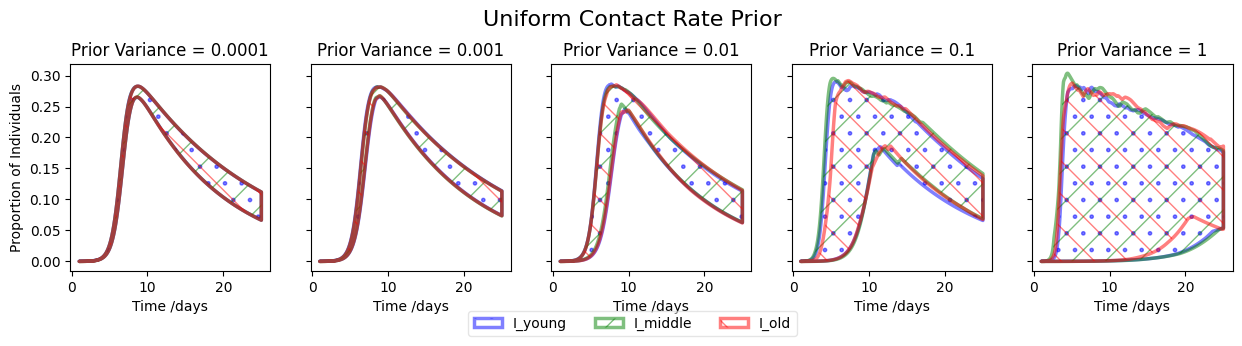

In [9]:
C_mean_uniform = torch.tensor([[0.33, 0.33, 0.33], 
                                [0.33, 0.33, 0.33], 
                                [0.33, 0.33, 0.33]])

run_scenario(C_mean_uniform, initial_state_a, "Uniform Contact Rate Prior")

Notice that all three age groups become infected at approximately the same time. As we increase our uncertainty about the contact matrix, we see more resulting uncertainty in the resulting infection trajectories.

## Part ii
"Simulate this model for the case where there is significant in-group contact preference – you may choose the numbers in the matrix to represent this in-group preference."





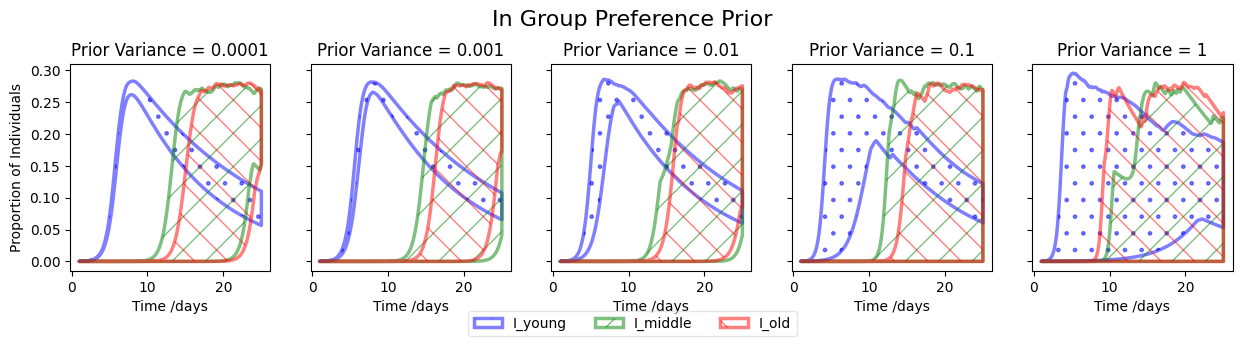

In [10]:
C_mean_in_group = torch.tensor([[1., 1e-6, 1e-6], 
                                [1e-6, 1., 1e-6], 
                                [1e-6, 1e-6, 1.]])

run_scenario(C_mean_in_group, initial_state_a, "In Group Preference Prior")

Notice how now with much lower between-group interaction, we see a significant lag between the young peak and the middle ages and older peak. This shifted peak is because we set the initial conditions to include only a single youth infected. Again, as we increase our uncertainty about the contact matrix, we see more resulting uncertainty in the resulting infection trajectories

## Part iii
"Simulate this model for the case where there is no contact between age groups. You may choose the numbers in the matrix, but ensure it meets the requirement of no contact between age groups."

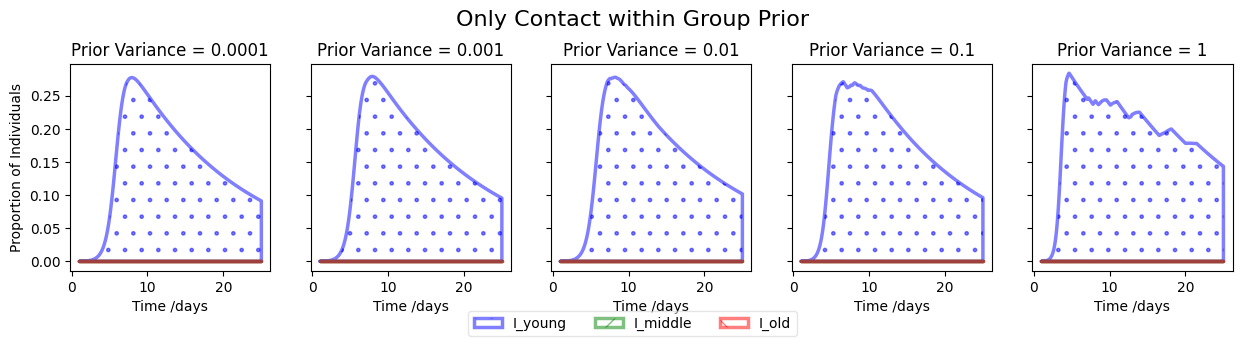

In [11]:
C_mean_in_group_extreme = torch.tensor([[1., 0., 0.], 
                                        [0., 1., 0.], 
                                        [0., 0., 1.]])

run_scenario(C_mean_in_group_extreme, initial_state_a, "Only Contact within Group Prior")

Not surprisingly, when we set the cross-stratum interactions to 0 we see that no middle aged or elderly people ever become sick.

## Part iv
"Simulate social distancing by scaling down the uniform contact matrix by a factor (e.g. multiply by 0.5)"

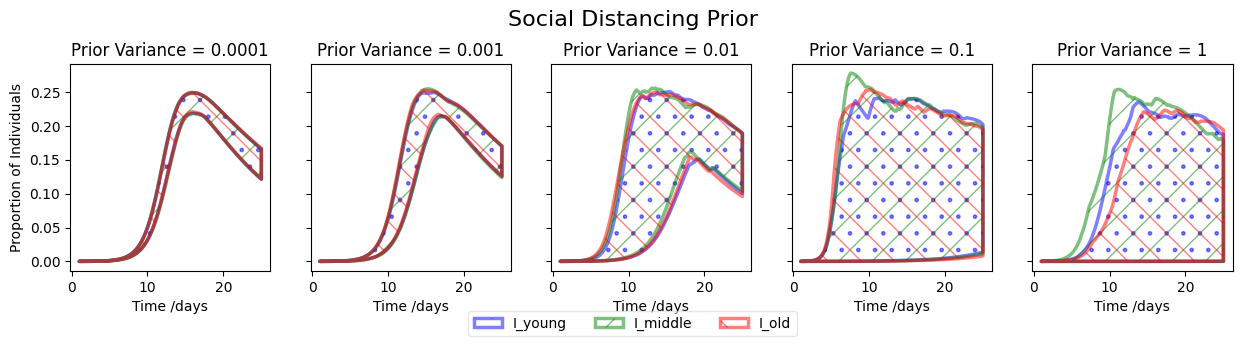

In [12]:
run_scenario(C_mean_uniform * 0.5, initial_state_a, "Social Distancing Prior")

These results look similar to the earlier "uniform contact rate" plots. However, we see a general reduction in the infections and a delayed peak.

## Part v
"Repeat 1.a.iv for the scenario where the young population has poor compliance with social distancing policies, but the old population is very compliant."

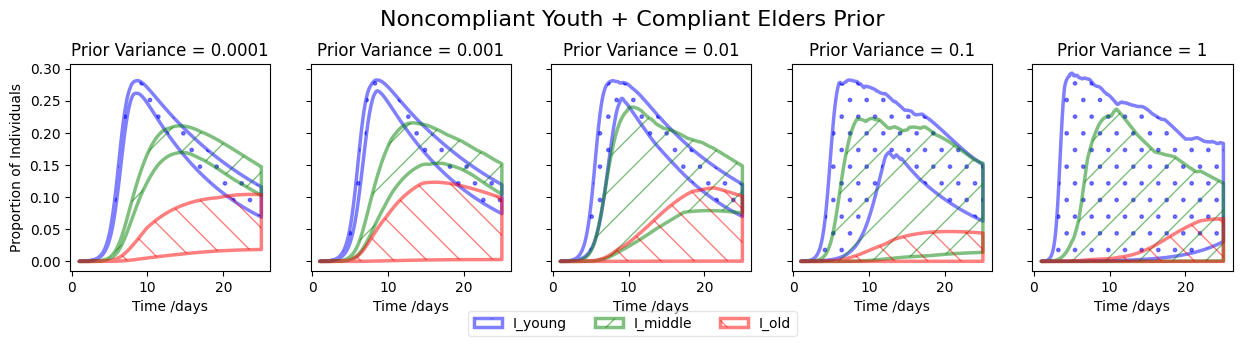

In [13]:
C_mean_noncompliant = torch.tensor([[0.9, 0.1, 0.01], 
                                    [0.1, 0.1, 0.01], 
                                    [0.01, 0.01, 0.01]])

run_scenario(C_mean_noncompliant, initial_state_a, "Noncompliant Youth + Compliant Elders Prior")

Again, here we see the result of infections flowing from young to middle and elderly, resulting in a delayed peak between groups.

**Subtask B** - "Repeat 1.a for a younger-skewing population: N_young = 3k, N_middle = 2k, N_old = 1k"

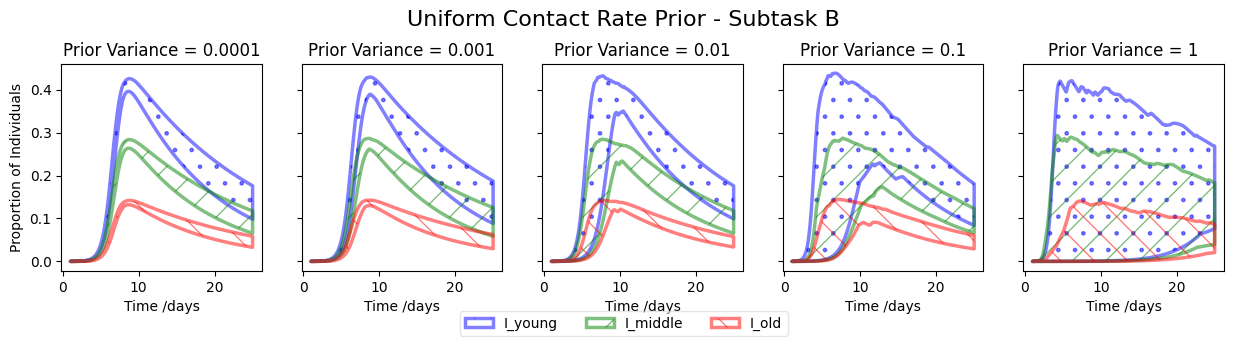

In [14]:
initial_state_b = (torch.tensor([[2999., 2000., 1000.]]), torch.tensor([[1., 0., 0.]]), torch.zeros(1, 3))
initial_state_b = tuple(torch.as_tensor(s)/N for s in initial_state_b)

run_scenario(C_mean_uniform, initial_state_b, "Uniform Contact Rate Prior - Subtask B")

Here the change in population does not affect the timing of the peaks, only their magnitude. This is true for both this and the following experiments.

**Subtask C** - "Repeat 1.a for an older-skewing population: N_young = 1k, N_middle = 2k, N_old = 3k"

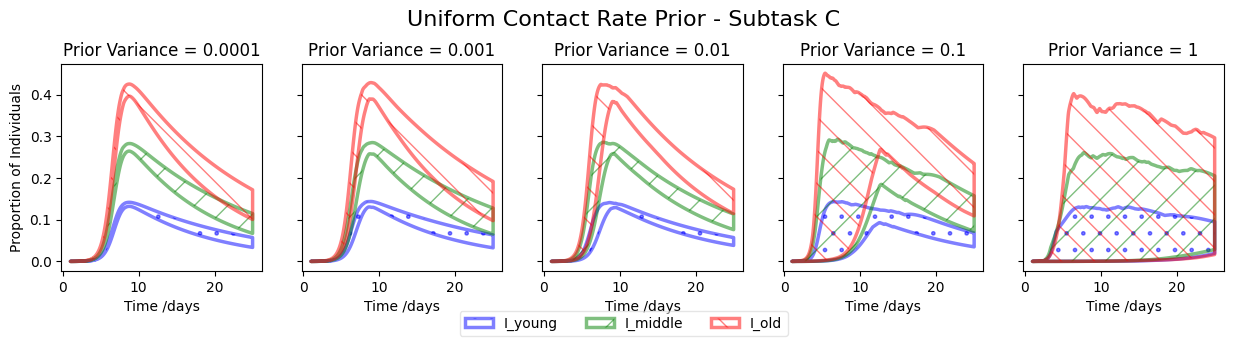

In [15]:
initial_state_c = (torch.tensor([[999., 2000., 3000.]]), torch.tensor([[1., 0., 0.]]), torch.zeros(1, 3))
initial_state_c = tuple(torch.as_tensor(s)/N for s in initial_state_c)

run_scenario(C_mean_uniform, initial_state_c, "Uniform Contact Rate Prior - Subtask C")

**Subtask D** - "Compare simulation outputs from 1a-c, and describe any takeaways/conclusions."

In general, adding variance to the contact matrix provides information about which features of the simulation are robust to uncertainty and which features are sensitive to the specific values of the contact matrix. One feature that displays this property is the timing of the peak of infection for worst case scenarios, where the peak of infection was high, and scenarios where the peak of infection never exceeds a threshold. No matter which initial contact matrix we were given, the timing of the peak of infection for worst case scenarios was robust to variance in the contact matrix. However, for average and best-case scenarios, the timing of the peak of infection was much more sensitive to variance in the contact matrix. This has implications for controllability: interventions that directly target preventing worst-case scenarios are more likely to be effective than interventions that hope to modify the peak of infection for best or average case scenarios.

# **Question 2.** 
"Now find real contact matrix data and stratify the basic SIR model with the appropriate number of age groups to match the data found. To simulate the model with realistic initial values, find data on population distribution by age group. As in question 1, let gamma = 1/14 days, and let R0 = 5. Assume gamma, beta, and R0 are the same for all age groups."

**Subtask A** - "If the data you’ve found supports this, compare the situation for a country with significant multi-generational contact beyond two generations (as indicated by multiple contact matrix diagonal bandings), and for a country without."

In [16]:
import pandas as pd
import os
data_path = "./notebook/evaluation/scenario_1_data/"

C_belgium = torch.tensor(pd.read_csv(data_path + "belgium_all_locations_cm.csv").values)
C_india   = torch.tensor(pd.read_csv(data_path + "india_all_locations_cm.csv").values)

# Both datasets apparently go in 5 year increments (although that is not clearly noted in the files)
# However, the population data includes more bins, so we simple squash 70-75, 75-80, etc. bins all into a single 
# 70+ bin to get alignment.
belgium_populations = torch.tensor(pd.read_csv(data_path + "2022_ Belgium_population_by_age.csv").values[2][1:-2].astype('float'))
S_belgium = torch.zeros(1, 16)
S_belgium[0, :15] = belgium_populations[:15]
S_belgium[0, 15] = torch.sum(belgium_populations[15:])
S_belgium[0, 0] -= 1

N_belgium = torch.sum(belgium_populations)

I_belgium = torch.zeros_like(S_belgium)
I_belgium[0] = 1.

R_belgium = torch.zeros_like(S_belgium)

initial_state_belgium = (S_belgium, I_belgium, R_belgium)
initial_state_belgium = tuple(torch.as_tensor(s)/N_belgium for s in initial_state_belgium)

# India data does not include a "total" column, hence the slight changes in data processing.
india_populations = torch.tensor(pd.read_csv(data_path + "2016_india_population_by_age.csv").values[0, 2:].astype('float'))
S_india = torch.zeros(1, 16)
S_india[0, :15] = india_populations[:15]
S_india[0, 15] = torch.sum(india_populations[15:])
S_india[0, 0] -= 1

N_india = torch.sum(india_populations)

I_india = torch.zeros_like(S_india)
I_india[0] = 1.

R_india = torch.zeros_like(S_india)

initial_state_india = (S_india, I_india, R_india)
initial_state_india = tuple(torch.as_tensor(s)/N_india for s in initial_state_india)


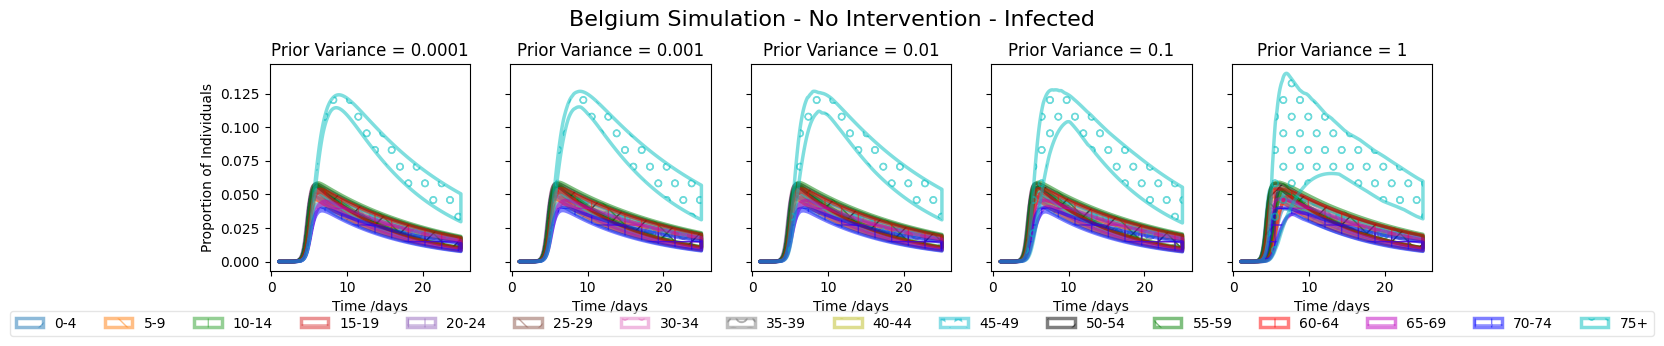

In [17]:
labels = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75+"]
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '/', '\\', '|', '-', '+', 'o']
edgecolors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive' ,'tab:cyan', 'black', 'g', 'r', 'm', 'b', 'c']

run_scenario(C_belgium, initial_state_belgium, "Belgium Simulation - No Intervention - Infected", labels=labels, hatches=hatches, edgecolors=edgecolors)

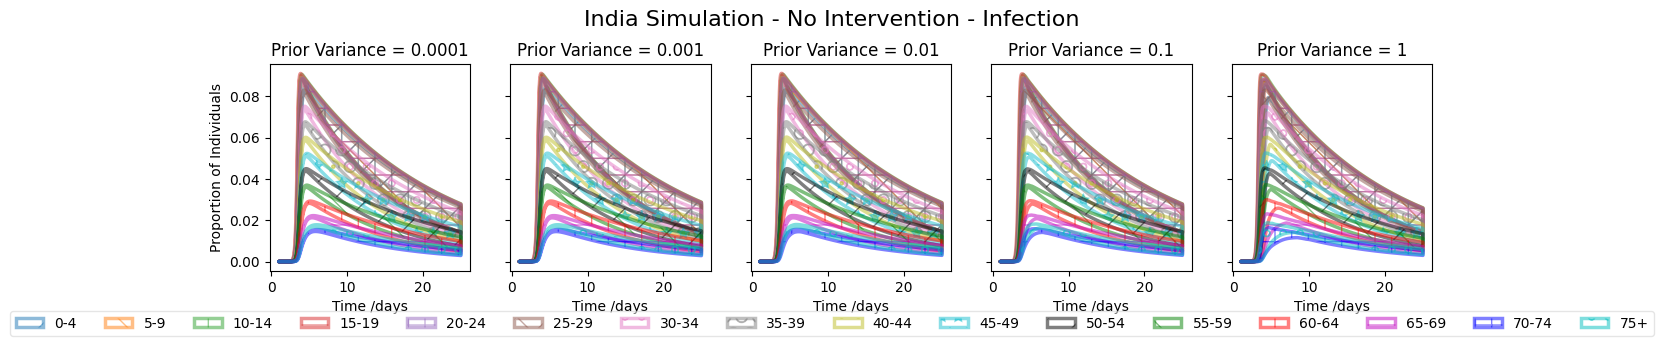

In [18]:
run_scenario(C_india, initial_state_india, "India Simulation - No Intervention - Infection", labels=labels, hatches=hatches, edgecolors=edgecolors)

**Subtask B** - "If the data supports this, try implementing interventions like: (1) School closures (2) Social distancing at work and other locations, but not at home."

First we'll implement the two interventions by simply manipulating the contact matrix. Then, we'll apply more richly structured interventions using pyciemss primitives that depend on time.

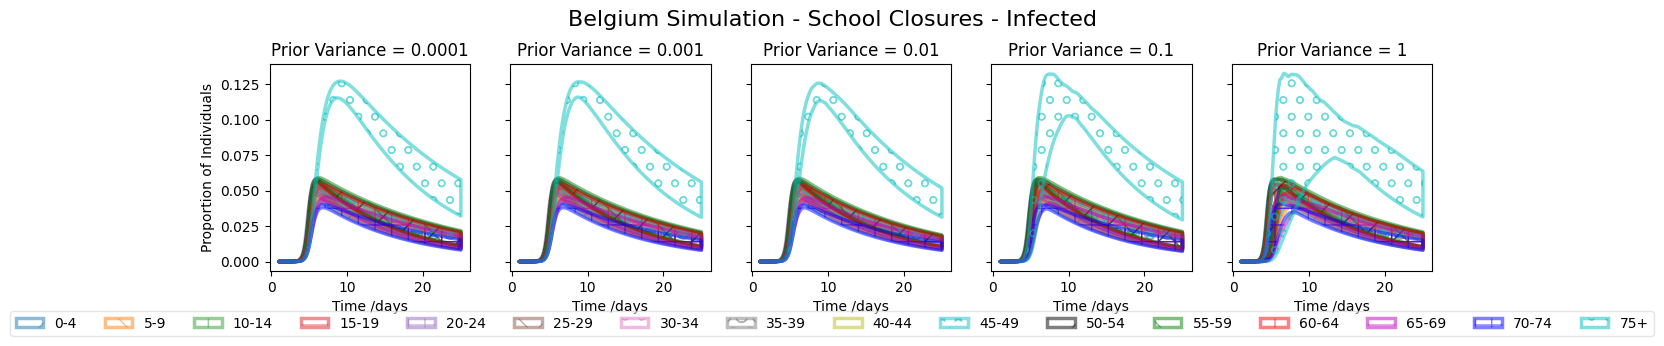

In [19]:
C_belgium_closures = torch.clone(C_belgium)

# Decrease the contact rate for children age 5-19 by a factor of 0.3.
C_belgium_closures[1:3, 1:3] = C_belgium[1:3, 1:3] * 0.3

run_scenario(C_belgium_closures, initial_state_belgium, "Belgium Simulation - School Closures - Infected", labels=labels, hatches=hatches, edgecolors=edgecolors)

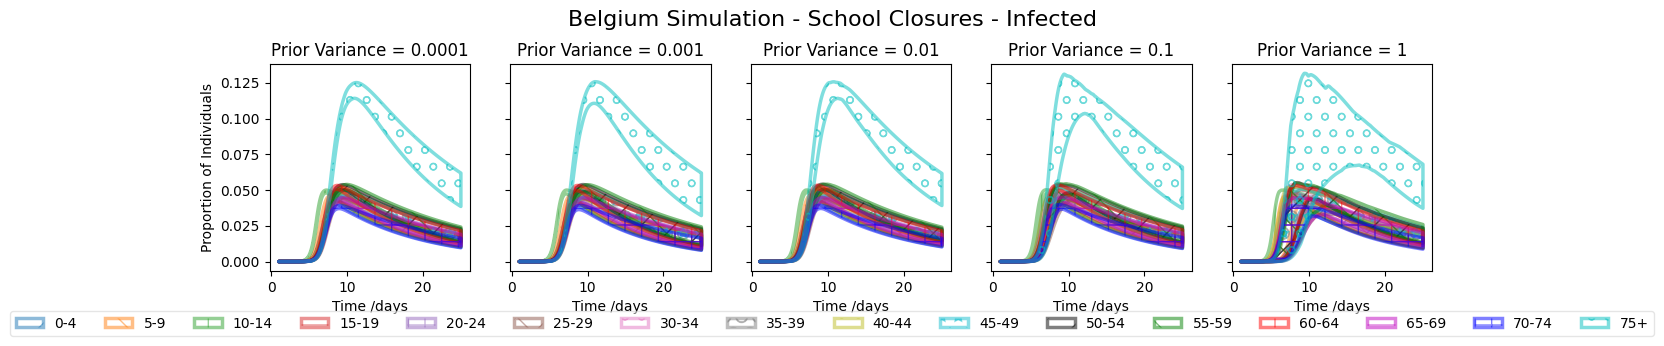

In [20]:
C_belgium_work = torch.clone(C_belgium)

# Decrease the contact rate for adults age 20-64 by a factor of 0.3.
C_belgium_work[3:12, 3:12] = C_belgium[3:12, 3:12] * 0.3

run_scenario(C_belgium_work, initial_state_belgium, "Belgium Simulation - School Closures - Infected", labels=labels, hatches=hatches, edgecolors=edgecolors)

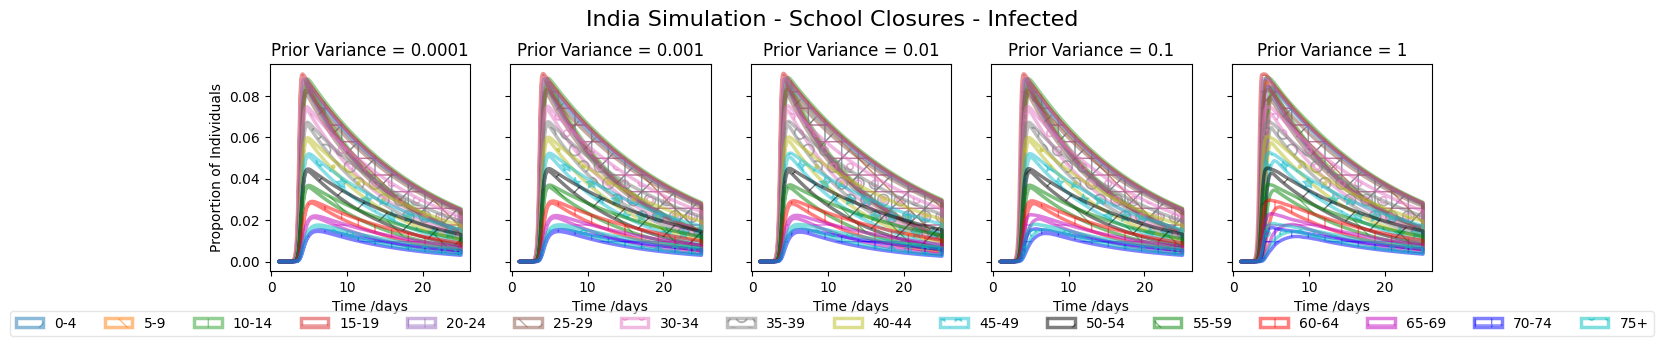

In [21]:
C_india_closures = C_india

# Decrease the contact rate for children age 5-19 by a factor of 0.3.
C_india_closures[1:3, 1:3] = C_india[1:3, 1:3] * 0.3

run_scenario(C_india_closures, initial_state_india, "India Simulation - School Closures - Infected", labels=labels, hatches=hatches, edgecolors=edgecolors)

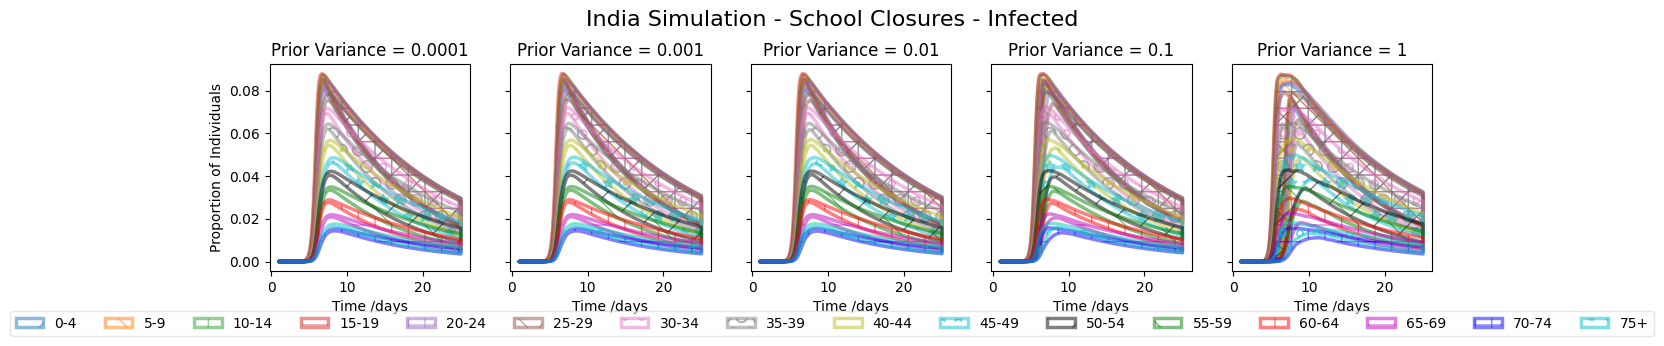

In [22]:
C_india_work = C_india

# Decrease the contact rate for adults age 20-64 by a factor of 0.3.
C_india_work[3:12, 3:12] = C_india[3:12, 3:12] * 0.3

run_scenario(C_india_work, initial_state_india, "India Simulation - School Closures - Infected", labels=labels, hatches=hatches, edgecolors=edgecolors)

To demonstrate one of the unique benefits of the CIEMSS causal probabilistic programming approach, we lightly elaborate on the interventions above.
Specifically, we implement a more sophisticated intervention using the `time_and_state_dependent_intervention_builder` from the `pyciemss` library. This allows us to intervene on contact rates using an arbitrary user-specified function of time and state. In the following small code segment, we show how to implement a draconian intervention that removes all contact entirely between individuals after 5 day. However, after 10 days many teenagers and young adults find out how to sneak out and socialize with each other even after the curfew is initiated. They're so upset with the curfew that they spend a lot of time together.

In [23]:
from pyciemss.ODE.interventions import time_and_state_dependent_intervention_builder

In [24]:
# Some teenagers are able to sneak out after the curfew. We represent that with this `curfew_scaling_tensor`

curfew_scaling_tensor = torch.zeros(16, 16)
curfew_scaling_tensor[3:6, 3:6] = 100.

def draconian_curfew(t, SI_flux):
    if t < 5:
        return SI_flux
    elif t > 10:
        return curfew_scaling_tensor * SI_flux
    else:
        return torch.zeros_like(SI_flux)

curfew_intervention = time_and_state_dependent_intervention_builder("SI_flux", draconian_curfew, tspan)

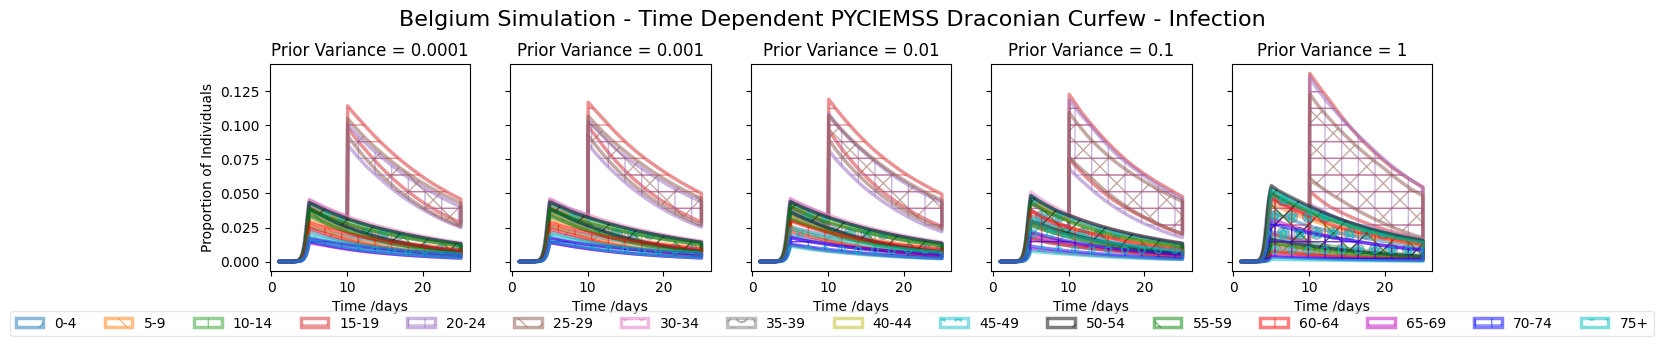

In [25]:
run_scenario(C_belgium, initial_state_belgium, "Belgium Simulation - Time Dependent PYCIEMSS Draconian Curfew - Infection", intervention=curfew_intervention, labels=labels, hatches=hatches, edgecolors=edgecolors)

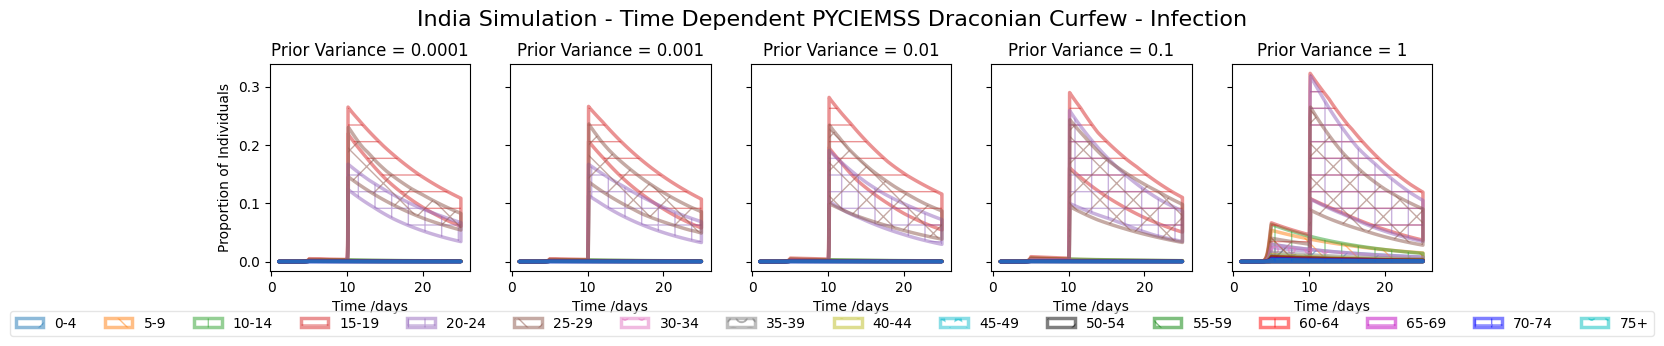

In [26]:
run_scenario(C_india, initial_state_india, "India Simulation - Time Dependent PYCIEMSS Draconian Curfew - Infection", intervention=curfew_intervention, labels=labels, hatches=hatches, edgecolors=edgecolors)